Import Libraries and functions

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from utils import load_data, high_corr, in_out_array, plot, statistics
from models import train, predict
from pathlib import Path

### 1-  Define the Path to Data Source (.xlsx File)
In this section, we define the file path to the dataset in an Excel file format. This path will be used to load our data in subsequent steps.

In [2]:
data_path = './data/ForecastAnalyst_CalgaryDailyEnergyDataset_2023.xlsx'

### 2- Load Dataset, Statistics, and Correlation Dataframes
Here, we load three different dataframes from the provided Excel file: the main dataset (init_df), a statistics dataframe (init_stats_df), and a correlation dataframe (init_corr_df). These dataframes will be used to analyze and build predictive models.

In [3]:
init_df, init_stats_df, init_corr_df = load_data(Path(data_path))


### 3 - Data Preprocessing
This section encompasses various data preprocessing steps to prepare the data for analysis and modeling.

#### 3-a) High Correlation Filtering

This step filters the features in the main dataset based on their linear correlation with energy consumption. Features with a correlation coefficient greater than or equal to 0.35 are selected.

In [10]:
filtered_df = high_corr(init_df[:2434], 0.35)

### 4-a) Selected Features

Here, we check for missing values within the filtered dataset and display the count of missing values for each feature. This step ensures that the data is clean and ready for modeling.

In [5]:
filtered_df.isnull().sum()

Energy               0
DLSav                0
LagDep(1)            0
YR2018_2019_WKDAY    0
YR2018_2019_WKEND    0
Sunday               0
Sun_Hol              0
LagHDD1              0
LagHDD2              0
dtype: int64

### 5-a) Dataframe to Array Conversion

We convert the filtered dataframe into NumPy arrays to make it suitable for training machine learning models. These arrays, year_x and year_y, represent the features and the target variable, respectively.

In [14]:
year_x, year_y = in_out_array(filtered_df)

### 6-a) Splitting Data into Train and Test Sets

We split the data into training and testing sets. The split is done in a way that 85% of the data is used for training, while the remaining 15% is reserved for testing.

In [22]:
x_train, x_test, y_train, y_test = train_test_split(year_x, year_y, test_size=0.15, random_state = 42)

### 7-a) Model Training

In this part, a parameter grid is defined for hyperparameter tuning. We create a Gradient Boosting Regressor model and train it using the specified parameter grid.

In [24]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5, 0.2],
    'max_depth': [3, 4, 5, 6]
}
init_model = GradientBoostingRegressor(random_state=42)
model = train(param_grid, init_model, x_train, y_train)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


After training, predictions are made on the test data, and the actual vs. predicted values are visualized in a plot.

In [25]:
y_pred = predict(model, x_test, y_test)

Mean Squared Error: 2218.948873182727
Mean Absolute Error: 31.983959218439136
R-squared: 0.7680739703158389


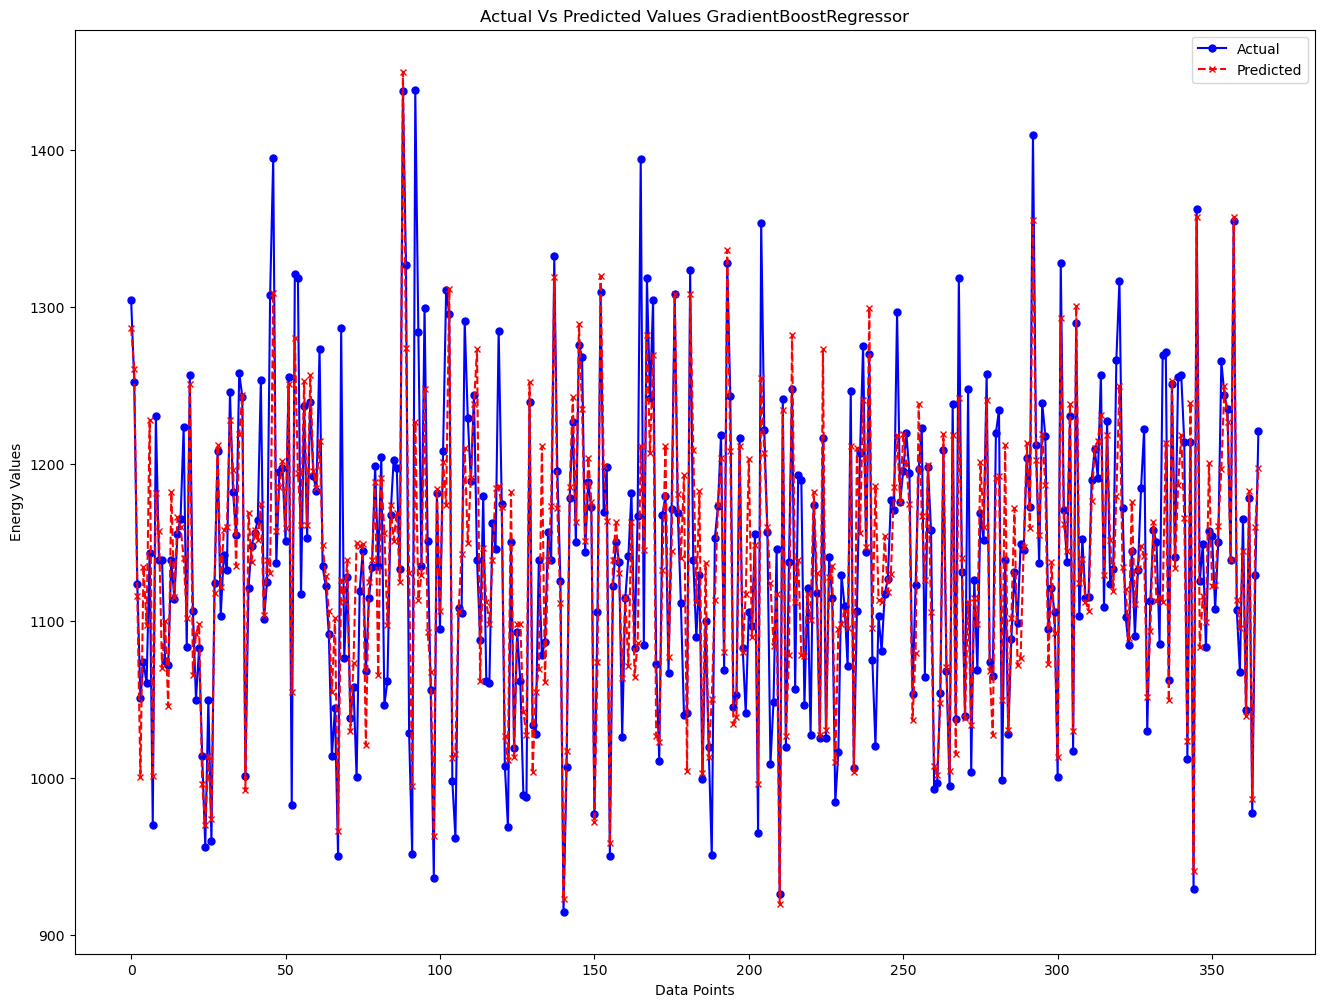

In [26]:
plot(y_pred,y_test,(16, 12), 'Data Points', 'Energy Values', 'Actual Vs Predicted Values GradientBoostRegressor')

In the following we attempt to use a  more complex model - SVR - however, due to the lack of data points and number of features, this model is not performing as good as the GradientBoostRegressor.

Best Hyperparameters: {'C': 10.0, 'epsilon': 0.3}
Mean Squared Error: 3941.682959274414
R-squared: 0.5119589214823896


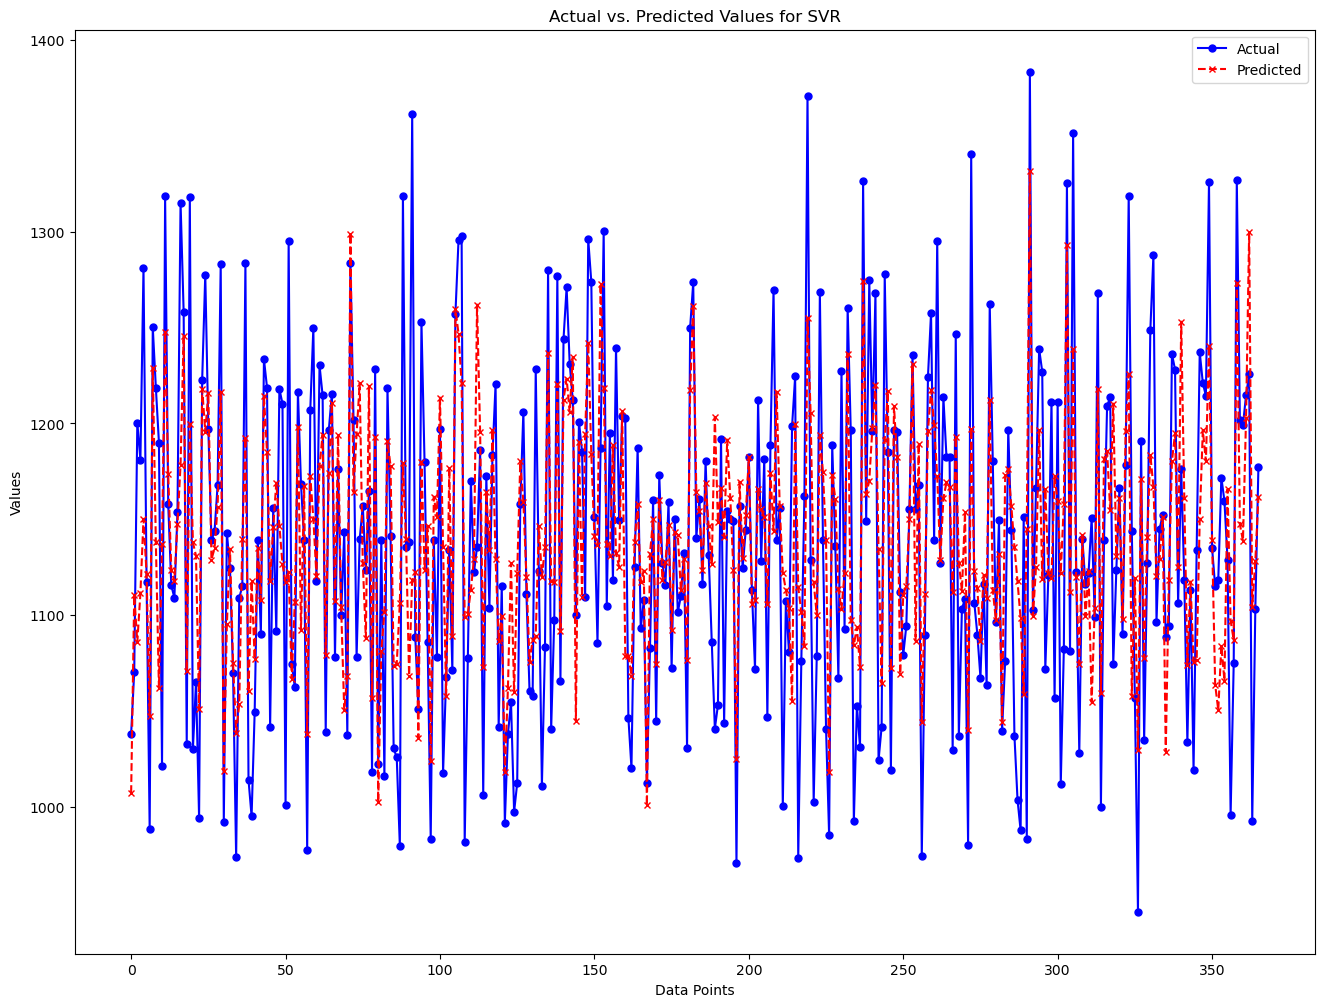

In [12]:
# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.1, 0.2, 0.3],
}

# Create the SVR model
svr = SVR(kernel='rbf')

# Create GridSearchCV with cross-validation
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best SVR model
best_svr = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_svr.predict(x_test)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Create a line plot to visualize the actual and predicted values in one dimension
plt.figure(figsize=(16, 12))
x = np.arange(len(y_test))  # Create an array of indices
plt.plot(x, y_test, label='Actual', color='blue', marker='o', linestyle='-', markersize=5)
plt.plot(x, y_pred, label='Predicted', color='red', marker='x', linestyle='--', markersize=5)
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values for SVR')
plt.legend()
plt.show()

### 3-b) Summer portion of Data
This section involves filtering the data to include only the summer months (June, July, and August). Similar preprocessing steps as in the previous section are applied to this filtered dataset.

In [11]:
summer_df = init_df[(init_df.June==1) | (init_df.July == 1) | (init_df.August == 1)]
summer_df

,Year,Month,Day,Energy,EndShift,COVID19,HLight,DLSav,TimeTrend,NYDAY,...,AfterDB,EvenDB,LagEvenDB,LagHDD1,LagHDD2,LagCDD,December,Bad,XMissing,YMissing
151,2017,6,1,1219.694614,0,0.0,16.254202,1,882,0,...,20.950000,20.100000,22.683333,0.0,0.0,7.191667,0,0,0,0
152,2017,6,2,1172.821785,0,0.0,16.283814,1,883,0,...,20.483334,18.800000,20.100000,0.0,0.0,5.554167,0,0,0,0
153,2017,6,3,1046.901204,0,0.0,16.312062,1,884,0,...,24.166667,22.400000,18.800000,0.0,0.0,4.670833,0,0,0,0
154,2017,6,4,1029.656914,0,0.0,16.338921,1,885,0,...,19.616667,17.783334,22.400000,0.0,0.0,4.662500,0,0,0,0
155,2017,6,5,1141.241540,0,0.0,16.364364,1,886,0,...,16.850000,15.833334,17.783334,0.0,0.0,3.341667,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,2023,8,27,1133.337416,1,0.0,13.875663,1,3160,0,...,25.740833,23.889000,23.796333,0.0,0.0,7.509250,0,0,0,0
2430,2023,8,28,1307.781640,1,0.0,13.813835,1,3161,0,...,29.444500,24.999833,23.889000,0.0,0.0,7.162083,0,0,0,0
2431,2023,8,29,1318.788780,1,0.0,13.751816,1,3162,0,...,29.352000,24.999833,24.999833,0.0,0.0,8.365667,0,0,0,0
2432,2023,8,30,1232.871479,1,0.0,13.689615,1,3163,0,...,21.296333,20.555500,24.999833,0.0,0.0,8.342542,0,0,0,0


In [12]:
filtered_summer_df = high_corr(summer_df, 0.4)

/Users/saragolestani/PycharmProjects/AESO/utils.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[f'{col}'].fillna((new_df[f'{col}'].mean()), inplace=True)


In [6]:
filtered_summer_df.isnull().sum()

Energy               0
LagDep(1)            0
YR2018_2019_WKDAY    0
YR2018_2019_WKEND    0
Sunday               0
Sun_Hol              0
NightDB              0
MornDB               0
AfterDB              0
EvenDB               0
LagEvenDB            0
LagCDD               0
dtype: int64

In [7]:
s_x_arr, s_y_arr = in_out_array(filtered_summer_df)

In [8]:
s_x_train = s_x_arr[:-92]
s_y_train = s_y_arr[:-92]
s_x_test = s_x_arr[-92:]
s_y_test = s_y_arr[-92:]

In [9]:
# Define the hyperparameters and their respective values to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5]
}

# Create the Gradient Boosting Regressor model
init_model = GradientBoostingRegressor(random_state=42)
model = train(param_grid, init_model, s_x_train, s_y_train)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [10]:
s_y_pred = predict(model, s_x_test, s_y_test)

Mean Squared Error: 1326.3368190363162
Mean Absolute Error: 29.328527712339554
R-squared: 0.8410912596684745


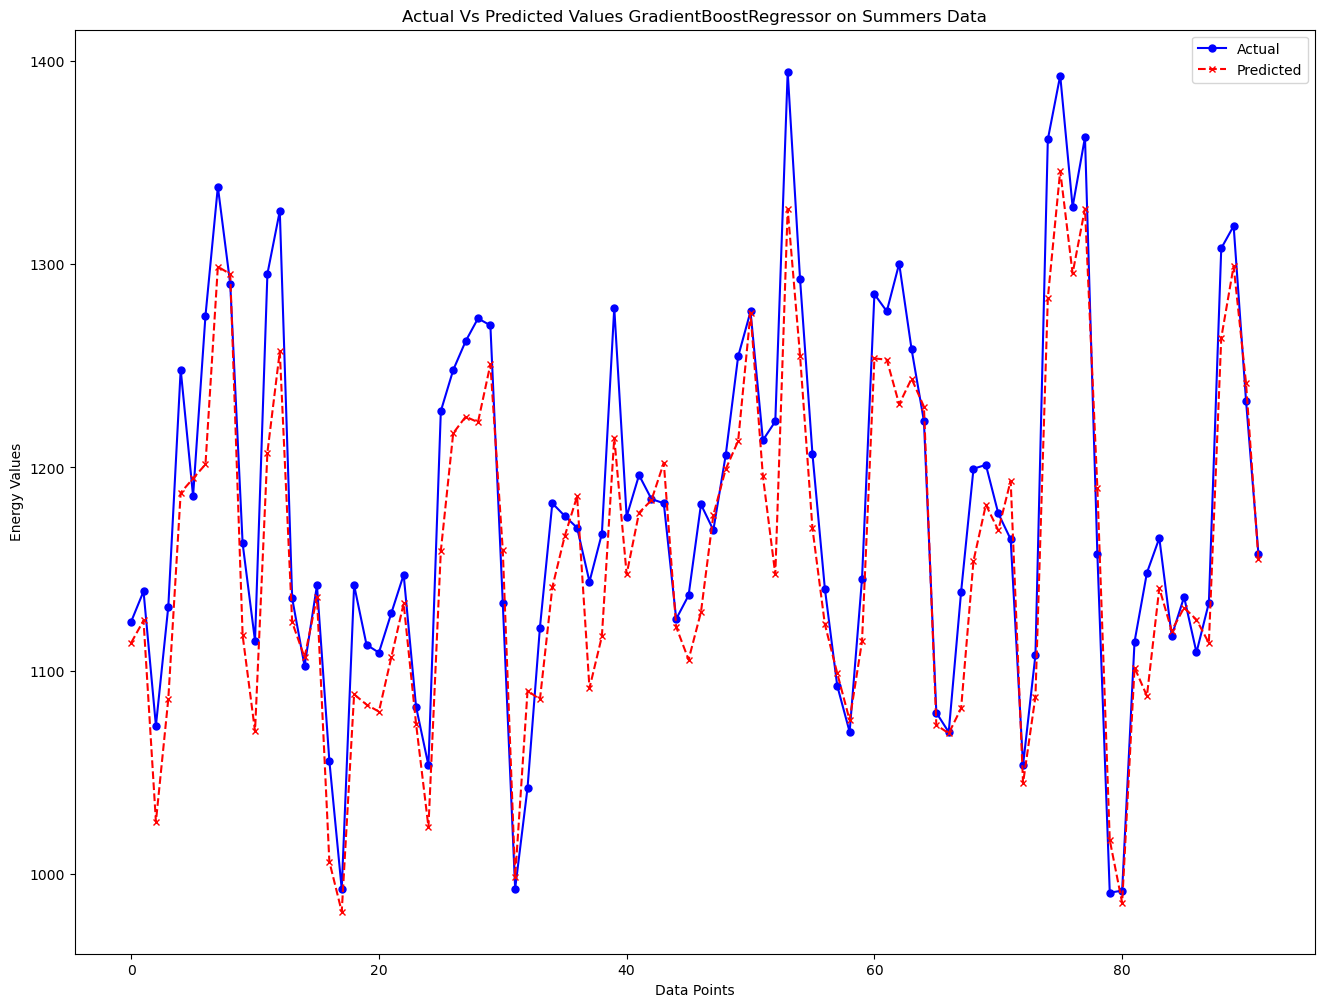

In [14]:
plot(s_y_pred, s_y_test, (16, 12), 'Data Points', 'Energy Values', 'Actual Vs Predicted Values GradientBoostRegressor on Summers Data')

### 3-c) Weekend Portion of Data
Here, the data is filtered to include weekends (Saturdays and Sundays) and holidays (Sun_Hol), and similar preprocessing steps are performed on this filtered dataset.

In [7]:
wend_df = init_df[(init_df['Saturday'] == 1) | (init_df['Sunday'] == 1) | (init_df['Sun_Hol'] == 1)]

In [8]:
filtered_wend_df = high_corr(wend_df, 0.4)

In [17]:
filtered_wend_df.isnull().sum()

Energy       0
HLight       0
DLSav        0
LagDep(1)    0
NightDB      0
MornDB       0
AfterDB      0
EvenDB       0
LagEvenDB    0
LagHDD1      0
LagHDD2      0
dtype: int64

In [18]:
wend_x, wend_y = in_out_array(filtered_wend_df)

In [19]:
wend_x_train, wend_x_test, wend_y_train, wend_y_test = train_test_split(wend_x, wend_y, test_size=0.1)

In [20]:
# Define the hyperparameters and their respective values to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5]
}
# Create the Gradient Boosting Regressor model
init_model = GradientBoostingRegressor(random_state=42)
model = train(param_grid, init_model, wend_x_train, wend_y_train)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [21]:
wend_y_pred = predict(model, wend_x_test, wend_y_test)

Mean Squared Error: 622.3751045640347
Mean Absolute Error: 19.198509432350786
R-squared: 0.9007493766322381


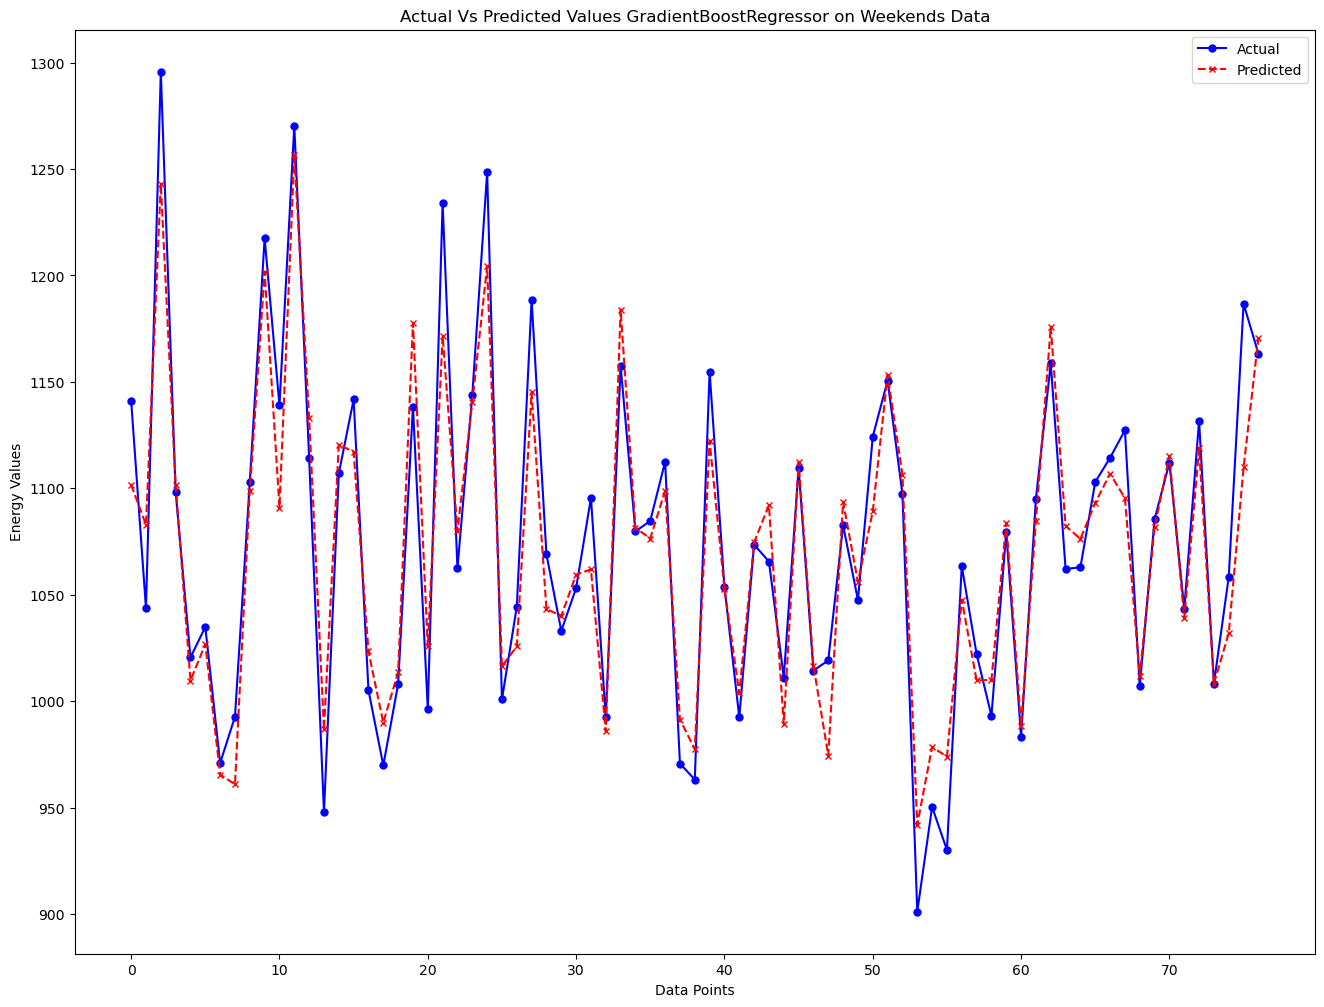

In [23]:
plot(wend_y_pred, wend_y_test, (16, 12), 'Data Points', 'Energy Values', 'Actual Vs Predicted Values GradientBoostRegressor on Weekends Data')


### 3-d) Covid Weekends
Data is filtered to include weekends and holidays with a COVID-19 rate greater than or equal to 0.01, followed by preprocessing steps similar to the previous sections.

In [4]:
wend_cov_df = init_df[((init_df['Saturday'] == 1) & (init_df['COVID19'] >= 0.01))| ((init_df['Sunday'] == 1)& (init_df['COVID19'] >= 0.01)) | ((init_df['Sun_Hol'] == 1) & (init_df['COVID19'] >= 0.01))]


In [5]:
filtered_wend_cov_df = high_corr(wend_cov_df, 0.4)

/Users/saragolestani/PycharmProjects/AESO/utils.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[f'{col}'].fillna((new_df[f'{col}'].mean()), inplace=True)


In [26]:
filtered_wend_cov_df.isnull().sum()

Energy       0
HLight       0
DLSav        0
TimeTrend    0
February     0
LagDep(1)    0
LagHDD1      0
LagHDD2      0
dtype: int64

In [27]:
wend_cov_x, wend_cov_y = in_out_array(filtered_wend_cov_df)

In [32]:
wend_cov_x_train, wend_cov_x_test, wend_cov_y_train, wend_cov_y_test = train_test_split(wend_cov_x, wend_cov_y, test_size=0.1)

In [33]:
# Define the hyperparameters and their respective values to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5]
}
# Create the Gradient Boosting Regressor model
init_model = GradientBoostingRegressor(random_state=42)
model = train(param_grid, init_model, wend_cov_x_train, wend_cov_y_train)

Best Hyperparameters: {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 100}


In [34]:
wend_cov_y_pred = predict(model, wend_cov_x_test, wend_cov_y_test)

Mean Squared Error: 1490.6367092883775
Mean Absolute Error: 29.192971416636368
R-squared: 0.7830812807062459


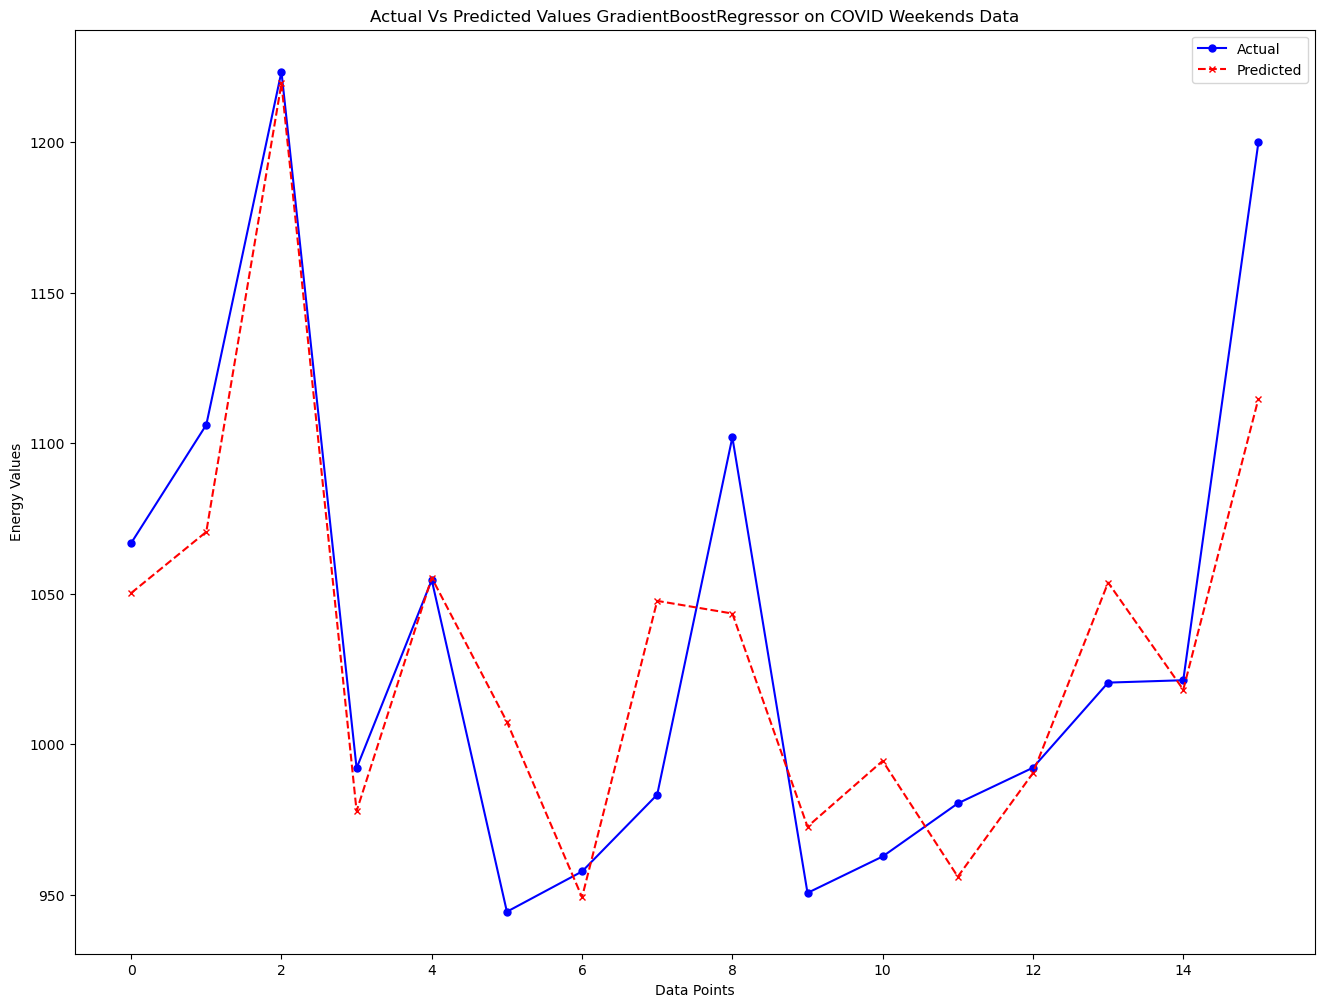

In [35]:
plot(wend_cov_y_pred, wend_cov_y_test, (16, 12), 'Data Points', 'Energy Values', 'Actual Vs Predicted Values GradientBoostRegressor on COVID Weekends Data')

### Statistics
This section computes and displays statistics for the selected features in each dataset, including `correlation with the energy column, mean, max, min, variance, skewness, and kurtosis`.

In [14]:
statistics(filtered_df)

Energy               1.000000
DLSav               -0.395610
LagDep(1)            0.742470
YR2018_2019_WKDAY    0.389226
YR2018_2019_WKEND   -0.505283
Sunday              -0.364648
Sun_Hol             -0.372215
LagHDD1              0.463539
LagHDD2              0.462167
Name: Energy, dtype: float64
For Energy we have 
 mean of : 1139.1525503947873 
 var of: 8235.867421946466 
 min of 901.089335971408 
 max of 1507.00618743896 
 skewness of 0.21847984160757997 
 kurtosis of 0.11439895810413914 
 and the goodness of fittest of 20.60536769809638
For DLSav we have 
 mean of : 0.6577649958915366 
 var of: 0.2252027297894256 
 min of 0 
 max of 1 
 skewness of -0.6654429436687673 
 kurtosis of -1.5584669455024927 
 and the goodness of fittest of 425.50392027872164
For LagDep(1) we have 
 mean of : 1139.0622579897636 
 var of: 8303.93466325661 
 min of 901.089335971408 
 max of 1507.00618743896 
 skewness of 0.21897190330654023 
 kurtosis of 0.07546284081688626 
 and the goodness of fittest of

In [13]:
statistics(filtered_summer_df)

Energy               1.000000
LagDep(1)            0.669719
YR2018_2019_WKDAY    0.439093
YR2018_2019_WKEND   -0.551449
Sunday              -0.401999
Sun_Hol             -0.398388
NightDB              0.590876
MornDB               0.610308
AfterDB              0.664637
EvenDB               0.650310
LagEvenDB            0.617411
LagCDD               0.586623
Name: Energy, dtype: float64
For Energy we have 
 mean of : 1142.0422322591146 
 var of: 10191.386033583265 
 min of 920.160429636637 
 max of 1507.00618743896 
 skewness of 0.17984657892171033 
 kurtosis of -0.22306387898545088 
 and the goodness of fittest of 4.882880899846788
For LagDep(1) we have 
 mean of : 1141.7319663543492 
 var of: 10173.916132674589 
 min of 920.160429636637 
 max of 1507.00618743896 
 skewness of 0.16999592844233094 
 kurtosis of -0.24003861163077955 
 and the goodness of fittest of 4.7308043376237805
For YR2018_2019_WKDAY we have 
 mean of : 0.5962732919254659 
 var of: 0.2411058412140292 
 min of 0 
 ma

In [9]:
statistics(filtered_wend_df)

Energy       1.000000
HLight      -0.468743
DLSav       -0.561364
LagDep(1)    0.776692
NightDB     -0.498798
MornDB      -0.511360
AfterDB     -0.484853
EvenDB      -0.471456
LagEvenDB   -0.475190
LagHDD1      0.644956
LagHDD2      0.579229
Name: Energy, dtype: float64
For Energy we have 
 mean of : 1062.9232869879015 
 var of: 5552.693276675471 
 min of 901.089335971408 
 max of 1345.8357925415 
 skewness of 0.6792194635402932 
 kurtosis of 0.33342786277196357 
 and the goodness of fittest of 62.00581544375162
For HLight we have 
 mean of : 12.354737837431598 
 var of: 8.702028810761558 
 min of 7.89561713717787 
 max of 16.5613837387567 
 skewness of -0.06564762402624368 
 kurtosis of -1.4100621251191134 
 and the goodness of fittest of 63.88439245408559
For DLSav we have 
 mean of : 0.6618798955613577 
 var of: 0.2240874417652198 
 min of 0 
 max of 1 
 skewness of -0.6857243364929497 
 kurtosis of -1.5337936572660342 
 and the goodness of fittest of 134.6684522052636
For LagDep(1)

In [6]:
statistics(filtered_wend_cov_df)

Energy       1.000000
HLight      -0.410186
DLSav       -0.498390
TimeTrend    0.416233
February     0.430448
LagDep(1)    0.817485
LagHDD1      0.592780
LagHDD2      0.517263
Name: Energy, dtype: float64
For Energy we have 
 mean of : 1021.9137094172723 
 var of: 6313.321875503409 
 min of 901.089335971408 
 max of 1345.8357925415 
 skewness of 1.2308441683852689 
 kurtosis of 1.8983721431857514 
 and the goodness of fittest of 58.08169767986432
For HLight we have 
 mean of : 13.012372579369163 
 var of: 8.94757751160868 
 min of 7.89665996661127 
 max of 16.5613837387567 
 skewness of -0.41266450335311916 
 kurtosis of -1.2796706424944937 
 and the goodness of fittest of 14.559932380022817
For DLSav we have 
 mean of : 0.7236842105263158 
 var of: 0.20128964796096213 
 min of 0 
 max of 1 
 skewness of -1.0104316318940547 
 kurtosis of -0.9922593916150975 
 and the goodness of fittest of 31.6776382251707
For TimeTrend we have 
 mean of : 2153.375 
 var of: 20071.216059602648 
 min of